# Food Classification using Pre-trained Models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/outputs
DATA_PATH = "drive/MyDrive/outputs"

densenet-0512-1linearlayer.pth	pretrained-model.pth  resnet-unfreeze-589.pth


# Get Data and CSVs

Download and get all the data images and files from the AI Crowd portal.

In [3]:
!pip install aicrowd-cli -q

     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 204kB 13.4MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 163kB 37.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [4]:
API_KEY = "c0377f0fb65414eaa12c1998de4c65c2" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [5]:
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

train_images.zip: 100% 754M/754M [00:19<00:00, 39.3MB/s]
test_images.zip: 100% 33.9M/33.9M [00:01<00:00, 27.2MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 1.03MB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 881kB/s]


In [6]:
!unzip -q train_images.zip

In [7]:
!unzip -q test_images.zip

# Imports

In [8]:
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from torchvision import transforms, utils, datasets, models

In [9]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=8d165ba7f670700b57cc82362868f473aa4dd5aa6fd06f11d051250f0159db18
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [10]:
from efficientnet_pytorch import EfficientNet

# Dataset Creation and Loader

In order use our training and test data for deep learning, it needs to be in a compatible format. All deep learning frameworks and libraries require the data in a specific format, in order to process it and train corresponding models. For this purpose, the ***Dataloader*** and ***Dataset Class*** are important methods. These help us to feed our own training data into the network. 

The Dataset class is used to provide an interface for accessing all the training or testing samples in the dataset. That is, it creates a class with methods in order to reference the different instances of the data samples. A custom data set class in python overrides the `__getitem__` and the `__len__` methods, so as to suite the requirements of the custom data format. 

Although we can access all the training data using the Dataset class, for deep learning, we would need *batching, shuffling, multiprocess data loading*, etc. DataLoader class helps us to do this. The DataLoader class accepts a dataset and other parameters such as `batch_size`, `batch_sampler` and `number of workers` to load the data .Then we can iterate over the Dataloader to get batches of training data and train our models.

**References**:

* To build a custom dataset and dataloader : [Reference](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

* Writing a Python Dataloader : [Reference](https://medium.com/analytics-vidhya/writing-a-custom-dataloader-for-a-simple-neural-network-in-pytorch-a310bea680af)

In [11]:
food_id2name = {}
food_name2id = {}

food_i = -1
with open("dataset_info.txt", 'r') as f:

    line = f.readline().strip()

    while(line):
        if food_i <= 0 :
            food_i+=1
            line = f.readline().strip()
            continue

        num, name = line.split(" ")
        num = int(num[:-1])
        food_id2name[food_i - 1] = name
        food_name2id[name] = food_i - 1

        food_i+=1
        line = f.readline().strip()

In [12]:
len(food_name2id)

61

In [16]:
class FoodDataset(Dataset):

    def __init__(self, csv_file, root_dir, dataset_type, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.food_df = pd.read_csv(csv_file)
        #self.food_df = self.food_df.head(100)
        self.root_dir = root_dir
        self.transform = transform
        self.dataset_type = dataset_type

    def __len__(self):
        return len(self.food_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.food_df.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.resize((256,256))
        # image = image.resize((299,299))     #for inception v3
        # image = image.resize((64,64))

        if self.dataset_type == "train":
            food_class = torch.tensor(food_name2id[self.food_df.iloc[idx, 1]])
            sample = {'image': image, 'food_class': food_class}
        else:
            sample = {'image': image}

        # if self.transform and self.food_df.iloc[idx, 1] != "water":
        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample


# Data Transformations

Many a times during training, the train data may not be fully representative of all the possibilities of input to the machine learning model. Especially for images, there could exist different orientations, angles, colours, intensities of the same image, thus causing differences in the input. Not all of these variations will be present in the dataset. Therefore, a suite of transformations used at training time is typically referred to as **data augmentation** and is a common practice for modern model development.

It performs the set of transformations *on fly* in each iteration. Hence it does not increase the actual scale of the data on the disk.

There exist multiple types of data augmentation techniques that can be applied to the train dataset images :

* Rotation, Horizontal and Vertical Flip, Affine transforms
* Colour Jitter variation transofrms
* Normalization to a particular $(\mu, \sigma)$ distribution
* Conversion to tensor transforms.

**Note :** 

The ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. This is required to convert all images to tensors in our dataloader. [Ref](https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9)

In [17]:
# image_transforms1 = {
#     "train": transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(10),
#         transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),
#         transforms.ColorJitter(brightness=0.2, contrast = 0.2, saturation =0.2),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ]),
#     "test": transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize(255),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])
# }
class AddGaussianNoise(object):
    def __init__(self, mean=0.1, std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):

        tensor = transforms.ToTensor()(tensor)
        noisy_tensor = tensor + torch.randn(tensor.size()) * self.std + self.mean
        noisy_image = transforms.ToPILImage()(noisy_tensor)

        return noisy_image
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

image_transforms1 = {
    "train": transforms.Compose([
        
        # AddGaussianNoise(),
        
        transforms.RandomRotation(45),
        transforms.RandomRotation(30),
        transforms.RandomRotation(120),
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(5),
        transforms.CenterCrop(size=224),
        
        # transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.5), saturation=(0.5,1.5), hue=(-0.1,0.1)),
        transforms.ColorJitter(),
        # transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),
        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        
        # AddGaussianNoise(),

        transforms.RandomRotation(30),
        transforms.RandomRotation(120),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(5),
        transforms.CenterCrop(size=224),
        
        #transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.5), saturation=(0.5,1.5), hue=(-0.1,0.1)),
        transforms.ColorJitter(),
        # transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),

        transforms.ToTensor(),
        transforms.Resize(224), #299 inception v3 #256 ow
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),

        # transforms.Resize(256),
        # transforms.TenCrop(224),
        # transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        # transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(crop) for crop in crops]))

    ])
}

In [18]:
image_transforms2 = {
    "train": transforms.Compose([
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.ToTensor()
    ])
}

In [19]:
food_train_dataset = FoodDataset(csv_file=os.path.join("train.csv"), 
                                 root_dir=os.path.join("train_images"), 
                                 dataset_type="train",
                                 transform = image_transforms1["train"]
                                 )

In [20]:
food_test_dataset = FoodDataset(csv_file=os.path.join("test.csv"), 
                                root_dir=os.path.join("test_images"), 
                                dataset_type="test",
                                 transform = image_transforms1["test"]
                                )

# Analyzing the Train and Test Data

To begin with, it's a good practice to get an overview of the data that is present. In this problem statement, the task is a ***classification task***. Therefore, it is good to see the distribution of classes in the train dataset, and whether there exists a bias/skewed distribution in the data. 

Here, there are `9323` train samples and `484` test data images. The normalized $64 * 64$ images of the first 8 train samples are shown below, to get an idea of how the train data looks like. 

Further, a normalized histogram of the number of occurences of each class is also plotted. We see that there does exist a skew in the distribution, as the samples of class `water` , `bread-white` are much higher than the classes `pickle`, `onion` etc.

In [21]:
print("Total train samples =", len(food_train_dataset))
print("Total test samples =", len(food_test_dataset))

Total train samples = 9323
Total test samples = 484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

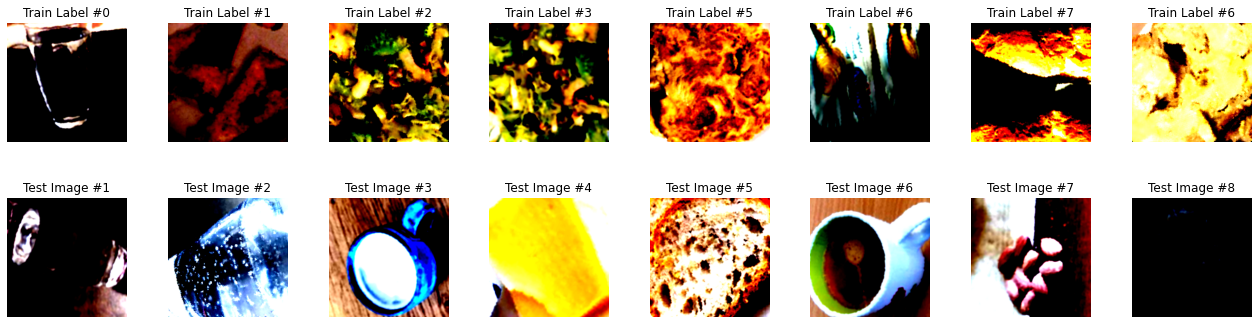

In [22]:
PLOT_IM = 8
fig, ax = plt.subplots(2, PLOT_IM, figsize = (18,5))
plt.tight_layout()

for i in range(0, PLOT_IM):
    sample1 = food_train_dataset[i]   
    ax[0][i].set_title('Train Label #{}'.format(sample1['food_class']))
    ax[0][i].axis('off')
    ax[0][i].imshow(sample1["image"].permute(1, 2, 0))   #EACH IMAGE IS OF THE SHAPE = (C x H x W)

    sample2 = food_test_dataset[i]
    ax[1][i].set_title('Test Image #{}'.format(i+1))
    ax[1][i].axis('off')
    ax[1][i].imshow(sample2["image"].permute(1, 2, 0))   #EACH IMAGE IS OF THE SHAPE = (C x H x W)   

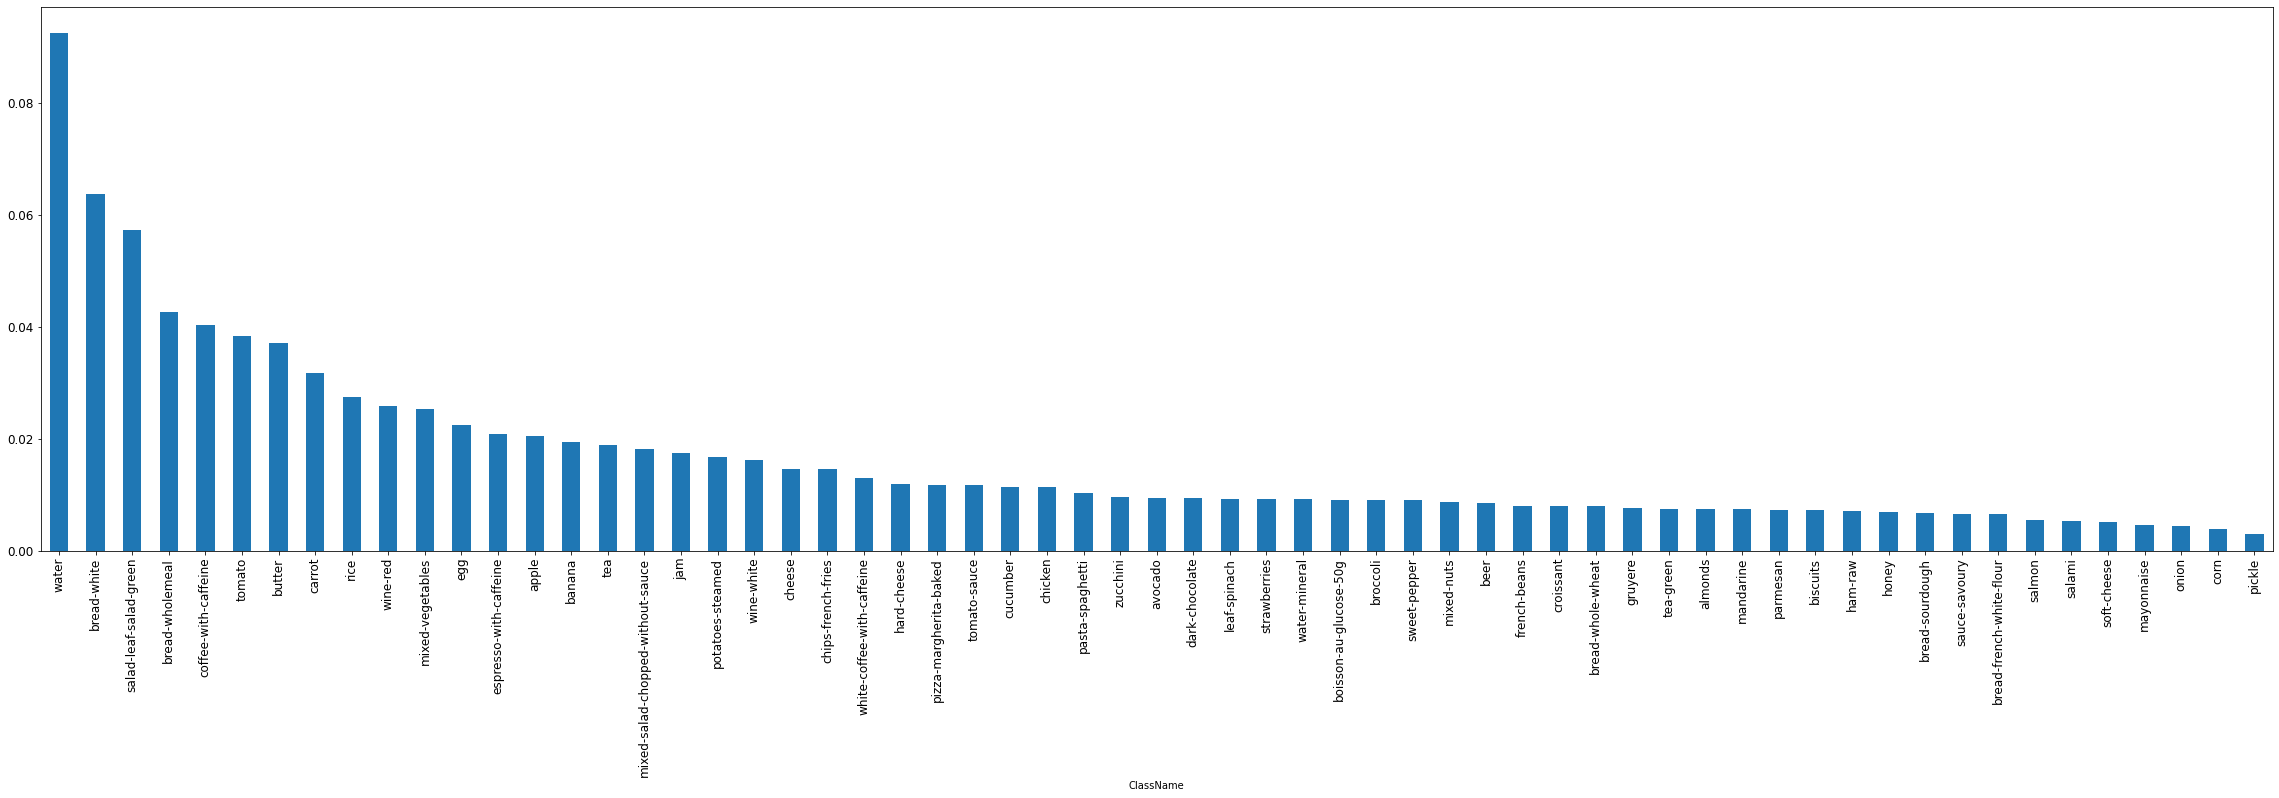

In [23]:
food_train_dataset.food_df.value_counts("ClassName", normalize=True).plot(x="ClassName", y="count", kind="bar", fontsize=12, figsize=(40,10))

In [24]:
#create the train validation and test dataloaders

BATCH_SIZE = 128
VAL_SPLIT = 0.1
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(food_train_dataset)
indices = list(range(len(food_train_dataset)))
split = int(np.floor(VAL_SPLIT * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# create the data samplers to use for sampling the sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [25]:
train_dataloader = DataLoader(food_train_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=train_sampler)
val_dataloader = DataLoader(food_train_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=val_sampler)
test_dataloader = DataLoader(food_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
print("Total train batches =", len(train_dataloader))
print("Total validation batches =", len(val_dataloader))
print("Total test batches =", len(test_dataloader))

Total train batches = 66
Total validation batches = 8
Total test batches = 4


# Build Image Classifier Model

For this task of classification of food into categories, three pretrained models were tried out. 1) **Resnet** and 2) **Densenet** 3) **Inception V3**

## RESNET : 

Resnet is a robust mechanism that helps train deep neural networks that often have issues with vanishing/exploding gradients. In resnet, this is done by the introduction of residual networks (blocks). The skip connections here, help us solve the issue. 

***Finetuning***:

* In order to finetune the network, two linear layers, followed by a LogSoftMax layer were added to the end of the network. This was done to tailor the pretrained model to meet the requirement of our classification task (61 classes).
* Further, experiments with the pretrained layers were also done, wherein a few layers were frozen and some were not. 



## DENSENET : 

In this architechture, it involves connecting each layer to every other layer in a feed-forward fashion. There exist multiple dense blocks of CNNs wherein outputs from the previous block are concatenated to the next, rather that summed up. This is the major difference between resnet and densnet. 

***Finetuning***

There were a couple of approaches that were tried for the fintuning in this case:
* Two Linear Layers at the end of the network, no dropout, 64*64 sized images
* Four Linear Layers at the end of the network, 64*64 sized images
* 4 Linear Layers at the end of the network, no dropout, 224*224 sized images
* Trying different versions of densenet - 121, 201

## INCEPTION V3

Inception AI is based on the exploration of ways to scale up networks in ways that aim at utilizing the added computation as efficiently as possible by suitably factorized convolutions and aggressive regularization. <sup>
[[1]](https://pytorch.org/hub/pytorch_vision_inception_v3/) </sup> Inception V3 uses the following to help improve the quality of predictions: 

* RMSProp Optimizer.
* Factorized 7x7 convolutions.
* BatchNorm in the Auxillary Classifiers.
* Label Smoothing (A type of regularizing component added to the loss formula that prevents the network from becoming too confident about a class. Prevents over fitting)

However, this model wasn't experimented much with, for this assigment.

**References :** 
* [Resnet](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)

* [What is Resnet](https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow) and its [architechture](https://www.mygreatlearning.com/blog/resnet/)

* [Densenet](https://pytorch.org/hub/pytorch_vision_densenet/)
* [Inception V3 Working](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
RESNET Pretrained Model
'''

model = models.resnet18(pretrained=True)
# unfreeze the weights
for param in model.parameters():
    param.requires_grad = True

# for name, child in model.named_children():
#    if name in ['layer1', 'layer2', 'layer3', 'layer4', 'fc', 'avgpool']:
#        print(name + ' is unfrozen')
#        for param in child.parameters():
#            param.requires_grad = True
#    else:
#        print(name + ' is frozen')
#        for param in child.parameters():
#            param.requires_grad = False

# adding a fully connected layer for the finetuning
model.fc = nn.Sequential(
                        #  nn.Linear(model.fc.in_features, 512),
                        #  nn.ReLU(),
                        #  nn.Dropout(0.2),
                        #  nn.Linear(512, 256),
                        #  nn.ReLU(),
                        #  nn.Dropout(0.2),
                        #  nn.Linear(256, 128),
                        #  nn.ReLU(),
                        #  nn.Dropout(0.2),
                        #  nn.Linear(128, 61),
                         nn.Linear(model.fc.in_features, 61),
                         nn.LogSoftmax(dim=1)
                         )
# loss_fn = nn.NLLLoss()
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.007)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.007, momentum=0.9)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.007, momentum=0.9)

'''
# DENSENET Pretrained Model
# '''
# model = models.densenet121(pretrained=True)
# #freeze the weights of the model
# for param in model.parameters():
#     param.requires_grad = False

# #classifier layer for densenet
# model.classifier = nn.Sequential(
#                                 #  nn.Linear(model.classifier.in_features, 512),
#                                 #  #nn.BatchNorm1d(512),
#                                 #  nn.ReLU(),
#                                 #  #nn.Dropout(0.2),

#                                 #  nn.Linear(512, 256),
#                                 #  #nn.BatchNorm1d(256),
#                                 #  nn.ReLU(),
#                                 #  #nn.Dropout(0.2),

#                                 #  nn.Linear(256, 128), #new layer
#                                 #  #nn.BatchNorm1d(128),
#                                 #  nn.ReLU(),
#                                 #  #nn.Dropout(0.2),

#                                 #  nn.Linear(128, 61),

#                                  nn.Linear(model.classifier.in_features, 61),
#                                  nn.LogSoftmax(dim=1)
#                                  )

# loss_fn = nn.NLLLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.000001)

'''
Inception v3 Pretrained Model
'''
# model = models.inception_v3(pretrained=True)
# #unfreeze the weights of the model
# for param in model.parameters():
#     param.requires_grad = True

# for name, child in model.named_children():
#    if name in ['AuxLogits', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c', 'avgpool', 'dropout', 'fc']:
#        print(name + ' is unfrozen')
#        for param in child.parameters():
#            param.requires_grad = True
#    else:
#        print(name + ' is frozen')
#        for param in child.parameters():
#            param.requires_grad = False

# model.fc = nn.Sequential(
#                         # nn.Linear(model.fc.in_features, 512),
#                         # nn.Tanh(),
#                         # nn.Linear(512, 256),
#                         # nn.ReLU(),
#                         # nn.Linear(256, 128), #new layer
#                         # nn.ReLU(),
#                         # nn.Linear(128, 61),
#                         nn.Linear(model.fc.in_features, 61),
#                         nn.LogSoftmax(dim=1)
#                         )

# loss_fn = nn.NLLLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.000001)

'''
Efficient Net Model
'''
# class Classifier(nn.Module):
#     def __init__(self,n_classes):
#         super(Classifier, self).__init__()
#         self.effnet =  EfficientNet.from_pretrained('efficientnet-b0')
#         self.l1 = nn.Linear(1000 , 256)
#         self.dropout = nn.Dropout(0.5)
#         self.l2 = nn.Linear(256,n_classes) # 62 is number of classes
#         self.relu = nn.LeakyReLU()
    
#     def forward(self, input):
#         x = self.effnet(input)
#         x = x.view(x.size(0),-1)
#         x = self.dropout(self.relu(self.l1(x)))
#         x = self.l2(x)
#         return x

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Classifier(61)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.003)


'''
Print model layer names
'''
for name, child in model.named_children():
    print(name)

'''
Loss function and Optimizer
'''

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)

model.to(device)
# print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training (FineTuning) the Model on train mages

In [29]:
EPOCHS = 20

In [30]:
train_losses, val_losses, val_accs = [], [] , []
min_val_loss = np.Inf

for epoch in tqdm.tqdm(range(EPOCHS)):

    #Run and finetune model on the train data
    model.train()
    train_loss = 0
    for batch in train_dataloader:

        images = batch['image'].to(device)
        labels = batch['food_class'].to(device)

        optimizer.zero_grad()
        outputs = model.forward(images) #specify .forward()
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        #print("train size = ", images.size(0))
        #print("train_loss", train_loss)
        #print("loss.item", loss.item())
        # print(outputs.shape)
        #print(outputs.data.shape)
        # break

    #Run and evaluate the model on the vlaidation data     
    val_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:

            images = batch['image'].to(device)
            labels = batch['food_class'].to(device)

            '''
            Without 10-crop testing
            '''
            #print(labels)

            outputs = model.forward(images)

            '''
            With 10 crop testing mechanism : 
            '''
            # input_var = torch.autograd.Variable(images, volatile=True)
            # target_var = torch.autograd.Variable(labels, volatile=True)
            # bs, ncrops, c, h, w = input_var.size()
            # temp_output = model(input_var.view(-1, c, h, w))
            # outputs = temp_output.view(bs, ncrops, -1).mean(1)

            batch_loss = loss_fn(outputs, labels)
            val_loss += batch_loss.item()*images.size(0)

            #print("val size = ", images.size(0))
            #print("vall_loss", val_loss)
            #print("loss.item", batch_loss.item())

            exp_outputs = torch.exp(outputs)  #take exponential since these are logsoftmax outputs

            #print("outputs")
            # print(outputs.shape)

            _, predicted = torch.max(exp_outputs.data, 1)
            # _, predicted = torch.max(outputs.data, 1)

            equals = predicted == labels.view(*predicted.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # print(images.shape)
            # print(predicted.shape)
            # print(labels.shape)

            # print(predicted)
            # print(labels)
            # break
            


    
    train_loss = train_loss/len(train_dataloader.sampler)
    val_loss = val_loss/len(val_dataloader.sampler)

    train_losses.append(train_loss)
    val_losses.append(val_loss)    

    val_accs.append(accuracy/len(val_dataloader))

    #scheduler.step(val_loss)

    
    print("Epoch ", epoch+1, "/", EPOCHS, end = '\t')
    print("Train Loss =", round(train_loss,4) , end = '\t')
    print("Validation Loss =", round(val_loss,4) , end = '\t')
    print("Validation Acc =", accuracy/len(val_dataloader) , end = '\n')
    # break

    if val_loss <= min_val_loss:
        print("Saving new model ...")
        min_val_loss = val_loss
        torch.save(model, os.path.join(DATA_PATH , 'pretrained-model.pth'))

    #break

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch  1 / 20	Train Loss = 2.6651	Validation Loss = 2.2577	Validation Acc = 0.3870442695915699
Saving new model ...


 10%|█         | 2/20 [05:48<52:11, 173.96s/it]

Epoch  2 / 20	Train Loss = 1.7879	Validation Loss = 1.9232	Validation Acc = 0.4721137136220932
Saving new model ...


 15%|█▌        | 3/20 [08:42<49:18, 174.03s/it]

Epoch  3 / 20	Train Loss = 1.5593	Validation Loss = 1.8588	Validation Acc = 0.45258246548473835
Saving new model ...


 20%|██        | 4/20 [11:34<46:12, 173.26s/it]

Epoch  4 / 20	Train Loss = 1.4406	Validation Loss = 1.799	Validation Acc = 0.4966362863779068
Saving new model ...


 25%|██▌       | 5/20 [14:25<43:09, 172.61s/it]

Epoch  5 / 20	Train Loss = 1.3378	Validation Loss = 1.813	Validation Acc = 0.4729817695915699


 30%|███       | 6/20 [17:18<40:18, 172.79s/it]

Epoch  6 / 20	Train Loss = 1.2451	Validation Loss = 1.7278	Validation Acc = 0.515625
Saving new model ...


 35%|███▌      | 7/20 [20:12<37:31, 173.19s/it]

Epoch  7 / 20	Train Loss = 1.1571	Validation Loss = 1.7549	Validation Acc = 0.5238715261220932


 40%|████      | 8/20 [23:07<34:43, 173.63s/it]

Epoch  8 / 20	Train Loss = 1.1146	Validation Loss = 1.723	Validation Acc = 0.5269097238779068
Saving new model ...


 45%|████▌     | 9/20 [26:01<31:51, 173.73s/it]

Epoch  9 / 20	Train Loss = 1.0055	Validation Loss = 1.6998	Validation Acc = 0.5274522602558136
Saving new model ...


 50%|█████     | 10/20 [28:56<29:00, 174.09s/it]

Epoch  10 / 20	Train Loss = 0.9655	Validation Loss = 1.7727	Validation Acc = 0.5023871511220932


 55%|█████▌    | 11/20 [31:50<26:07, 174.14s/it]

Epoch  11 / 20	Train Loss = 0.8864	Validation Loss = 1.8055	Validation Acc = 0.5205078125


 60%|██████    | 12/20 [34:44<23:13, 174.14s/it]

Epoch  12 / 20	Train Loss = 0.8464	Validation Loss = 1.8102	Validation Acc = 0.5265842005610466


 65%|██████▌   | 13/20 [37:40<20:22, 174.57s/it]

Epoch  13 / 20	Train Loss = 0.7774	Validation Loss = 1.8479	Validation Acc = 0.5093315988779068


 70%|███████   | 14/20 [40:34<17:27, 174.52s/it]

Epoch  14 / 20	Train Loss = 0.7351	Validation Loss = 1.8523	Validation Acc = 0.5262586809694767


 75%|███████▌  | 15/20 [43:29<14:32, 174.58s/it]

Epoch  15 / 20	Train Loss = 0.7209	Validation Loss = 1.9442	Validation Acc = 0.4998914934694767


 80%|████████  | 16/20 [46:24<11:38, 174.62s/it]

Epoch  16 / 20	Train Loss = 0.6443	Validation Loss = 1.8893	Validation Acc = 0.5160590261220932


 85%|████████▌ | 17/20 [49:17<08:42, 174.23s/it]

Epoch  17 / 20	Train Loss = 0.5897	Validation Loss = 2.0071	Validation Acc = 0.5323350727558136


 90%|█████████ | 18/20 [52:14<05:50, 175.13s/it]

Epoch  18 / 20	Train Loss = 0.5592	Validation Loss = 2.071	Validation Acc = 0.5108506977558136


 95%|█████████▌| 19/20 [55:09<02:55, 175.13s/it]

Epoch  19 / 20	Train Loss = 0.5274	Validation Loss = 2.0573	Validation Acc = 0.5133463516831398


100%|██████████| 20/20 [58:08<00:00, 174.41s/it]

Epoch  20 / 20	Train Loss = 0.5093	Validation Loss = 1.9379	Validation Acc = 0.5066189244389534


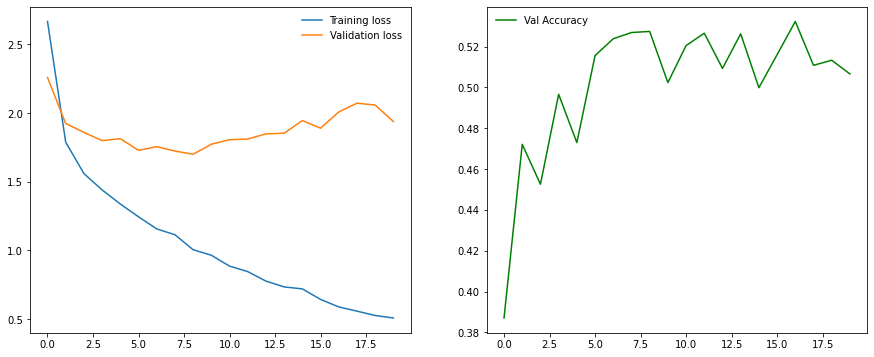

In [31]:
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend(frameon=False)

fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].legend(frameon=False)

ax[1].plot(val_accs, label='Val Accuracy', c='g')
ax[1].legend(frameon=False)

plt.show()

In [ ]:
model = torch.load(os.path.join(DATA_PATH,'resnet-unfreeze-589.pth'))
model.eval()
correct = 0
total = 0
preds = []
ground_truths = []

with torch.no_grad():
    for batch in (val_dataloader):
        images = batch['image'].to(device)
        labels = batch['food_class'].to(device)

        outputs = model(images)
        exp_outputs = torch.exp(outputs)
        _, predicted = torch.max(exp_outputs.data, 1)
        #print(outputs.data.shape)
        total += labels.size(0)
        
        print

        preds += [pr for pr in predicted.detach().cpu().numpy()]                
        ground_truths += [ truth for truth in labels.detach().cpu().numpy()]
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network = ', (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network =  57.081545064377686


## Conf Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns

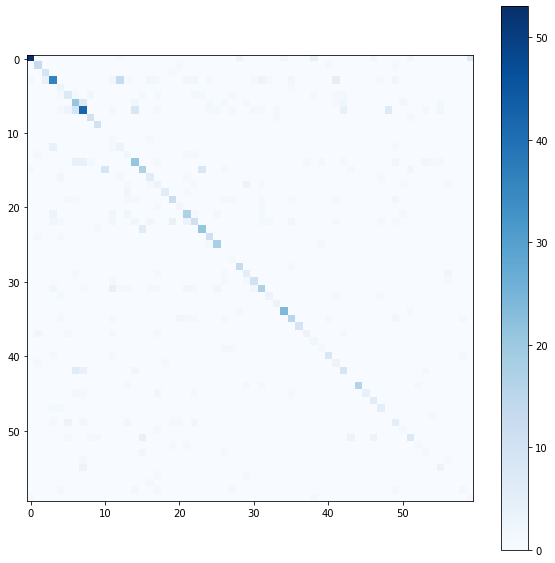

In [ ]:
cm = sklearn.metrics.confusion_matrix(preds, ground_truths)

fig = plt.figure(figsize = (10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()

## Prepare Submission

In [ ]:
model = torch.load(os.path.join(DATA_PATH,'resnet-unfreeze-589.pth'))
model.eval()
total = 0
test_preds = []

with torch.no_grad():

    cumulative_pred = None
    for i in range(7):
        
        inter_pred = None
        for batch in (test_dataloader):
            images = batch['image'].to(device)
            
            '''
            Without 10 crop testing
            '''
            outputs = model(images)
            
            '''
            With 10 crop testing
            '''
            # input_var = torch.autograd.Variable(images, volatile=True)
            # target_var = torch.autograd.Variable(labels, volatile=True)
            # bs, ncrops, c, h, w = input_var.size()
            # temp_output = model(input_var.view(-1, c, h, w))
            # outputs = temp_output.view(bs, ncrops, -1).mean(1)
            
            outputs = torch.exp(outputs)
            _, predicted = torch.max(outputs.data, 1)     
            # print(outputs)   
            # print(predicted)
            # for p in predicted:
            #     print(food_id2name[int(p.detach().cpu().numpy())])

            # break
            # test_preds+=[food_id2name[pr] for pr in predicted.detach().cpu().numpy()]          

            if inter_pred is None:
                inter_pred = outputs.cpu().numpy()
            else:
                inter_pred = np.vstack((inter_pred, outputs.cpu().numpy()))
        
        if cumulative_pred is None:
            cumulative_pred = inter_pred
        else:
            cumulative_pred += inter_pred

cumulative_pred = cumulative_pred

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
final_pred = np.argmax(cumulative_pred, axis=1)
test_preds += [food_id2name[pr] for pr in final_pred]

In [ ]:
len(test_preds)

484

In [ ]:
sub_df = pd.DataFrame(data=test_preds, columns=["ClassName"])
sub_df.head(20)

,ClassName
0,water
1,water
2,water
3,hard-cheese
4,bread-sourdough
5,espresso-with-caffeine
6,almonds
7,bread-wholemeal
8,water
9,coffee-with-caffeine


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


parmesan


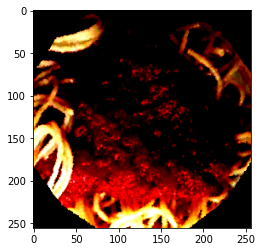

In [ ]:
for batch in (test_dataloader):
    images = batch['image'].to(device)
    print(test_preds[17])
    plt.imshow(images[17].permute(1, 2, 0).detach().cpu().numpy())
    break

In [ ]:
sub_df.to_csv("submission.csv", index = False)

In [ ]:
! tail -20 submission.csv

espresso-with-caffeine
rice
egg
bread-white
bread-white
bread-white
espresso-with-caffeine
water
mixed-vegetables
bread-wholemeal
ham-raw
salad-leaf-salad-green
coffee-with-caffeine
wine-white
potatoes-steamed
broccoli
pasta-spaghetti
water
bread-wholemeal
mixed-vegetables


In [ ]:
!aicrowd submission create -c chunin-exams-food-track-cv-2021 -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 7.8/6.1 KB • ? • 0:00:00
                                               ╭─────────────────────────╮                                               
                                               │ Successfully submitted! │                                               
                                               ╰─────────────────────────╯                                               
                                                     Important links                                                     
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021/submissions/130789              │
│                  │                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/chunin-ex

# Final Observations and Results : 

For the finetuning of the different pretrained models on the train data, the **SGD Optimizer** was used with a learning rate of `0.007`. The model was fine tuned using the **Negative Log Likelihood** Loss. This was done after trying a lot of many different hyperparameter values for the same.

The results for all the experiments for both the models (Resnet and Densenet) are tabulated below : 


|No.| Model | Unfrozen Layers|Image Size | Num Linear Layers  | F1 Score
|-| ---------|-----------|:-----:|:-:| ----|
|a)| Resnet18      |All |256 x 256| 1 |***0.589***| 
|b)| Resnet18      |L3, L4, FC |256 x 256| 1 |0.581| 
|c)| Densenet121    |FC         |224 x 224| 4 |0.533|
|d)| Densenet121    |FC         |224 x 224| 4 |0.519|
|e)| Resnet18      |FC         |224 x 224| 3 |0.467| 
|f)| Densenet201      |FC         |224 x 224| 3 |0.452| 
|g)| InceptionV3 |FC         |299 x 299| 4 |0.444|
|h)| Densenet121    |FC         |64 x 64  | 4 |0.441|
|i)| Densenet121    |FC         |64 x 64  | 2 |0.426|


# Helpful Factors

There were many things that were tried out in order to improve the accuracy. The hyperparameters that were helpful in doing so are explained below :


## 1. Data Augmentation and TTA : 

**Augmentation :**

Since the dataset consists of only 9323 train images, this is insufficient for a good amount of training. Hence, image augmentation is done. A number of different transforms are applied to the train dataset, thereby increasing the number of datasamples. These augmentaions include : 

* Horizontal and Vertical flips
* Rotation and Affine transformations
* Colour Jitter
* Random Crops and Crop Centers
* Gaussian Blur and Noise
* Normalization

In the ```a) Resnet``` model, all the transformations were applied, and it proves to have the highest accuracy amongst the rest. This shows that data augmentation can definitely have a positive impact on the classifier. 

Further, we see an increase in accuracy from ```h) Densenet``` to ```d) Densenet```. This is due to the ***increase in the image size***. This is another parameter that proves to be helpful. 

**Test Time Augmentation**

While predicted the labels for the test images with the trained model, in TTA, a confidence probability for each test image is generated. This is done for n number of times depending on the transofroms applied to the test images and finally the max average value among all the prediction classes is assigned to the image. <sup>[[1]](https://medium.com/analytics-vidhya/test-time-augmentation-using-pytorch-3da02d0a3188)</sup>

## 2. Freezing Layers + Custom Layers

**Freezing Layers**

In pretrained models, there exist a large number of layers of Convs, Linear, Max Pool Layers etc. While using the pretrained model for a fine-tuning task, there is an option to either freeze the weights of the model layers (ie : not update them) or unfreeze them such that the weights are altered by the backpropagation. 

The best results were obtained, when the upper layers of the pretrained models were unfrozen and the weights were allowed to be updated. 

**Custom Layers**

As for custom layers, when more layers were added to the FC layer/classifier layers in the pretrained models (with frozen weights), it was observed, that there wasn't any drastic improvement in the accuracy score.

# Graphs & Confusion Matrices



### a) <mark> Resnet</mark> model  ```Acc = 0.581``` vs ```Acc = 0.589```


|Resnet : 0.581 |      Resnet : 0.589   | 
|:----------------|:-----------------:|
| <img src="../graphs/pre-trained-graphs/resnet/tv-resnet-unfreeze-581.png" alt="Drawing" style="width: 450px;"/> |  <img src="../graphs/pre-trained-graphs/resnet/tv-resnet-unfreeze-589.png" alt="Drawing" style="width: 550px;"/> |

### Confusion Matrices

|Resnet : 0.581 |      Resnet : 0.589   | 
|:----------------|:-----------------:|
| <img src="../graphs/pre-trained-graphs/resnet/cm-resnet-unfreeze-581.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/pre-trained-graphs/resnet/cm-resnet-unfreeze-589.png" alt="Drawing" style="width: 350px;"/> |

### b) <mark> Densenet</mark> model  :


* ***More Augmentation vs Less***

|Densenet 121 : 0.519 |      Densenet 121 : 0.533   | 
|:----------------|:-----------------:|
| <img src="../graphs/pre-trained-graphs/densenet/densenet-0519.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/pre-trained-graphs/densenet/densenet-0533.png" alt="Drawing" style="width: 350px;"/> |

|Densenet 121 CM : 0.519 |      Densenet 121 CM : 0.533   | 
|:----------------|:-----------------:|
| <img src="../graphs/pre-trained-graphs/densenet/densenet-0519-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/pre-trained-graphs/densenet/densenet-0533-cm.png" alt="Drawing" style="width: 350px;"/> |



* ***Densenet 201 vs 121***

|Densenet 201 : 0.452 |      Densenet 121 : 0.426   | 
|:----------------|:-----------------:|
| <img src="../graphs/pre-trained-graphs/densenet/densenet201-tv.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/pre-trained-graphs/densenet/densenet-042.png" alt="Drawing" style="width: 350px;"/> |


### c) <mark> Inception V3</mark> model  : ```Acc = 0.444``` :

<img src="../graphs/pre-trained-graphs/inception-pretrained-val444.png" alt="Drawing" style="width: 350px;"/>
